# Classification

This notebook performs classification of images (square or circle).

In [18]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim

from cnn_framework.dummy_cnn.data_set import DummyCnnDataSet
from cnn_framework.dummy_cnn.model_params import DummyModelParams
from cnn_framework.dummy_cnn.model import DummyCnn
from cnn_framework.utils.data_loader_generators.classifier_data_loader_generator import (
    ClassifierDataLoaderGenerator,
)
from cnn_framework.utils.model_managers.cnn_model_manager import CnnModelManager
from cnn_framework.utils.data_managers.default_data_manager import DefaultDataManager
from cnn_framework.utils.metrics.classification_accuracy import ClassificationAccuracy

In [19]:
params = DummyModelParams()
params.update()

print(f"\nModel will be saved in {params.models_folder}")
print(f"Predictions will be saved in {params.output_dir}")
print(f"Tensorboard logs will be saved in {params.tensorboard_folder_path}")

Model time id: 20231117-111533-local
epochs 25 | batch 32 | lr 0.0001 | weight decay 0.0 | dropout 0.0 | c [0, 1, 2] | z [0]

Model will be saved in C:\Users\thoma\cnn_framework\src\cnn_framework\data\models/dummy_cnn/20231117-111533-local
Predictions will be saved in C:\Users\thoma\cnn_framework\src\cnn_framework\data\predictions/dummy_cnn/20231117-111533-local
Tensorboard logs will be saved in C:\Users\thoma\cnn_framework\src\cnn_framework\data\tensorboard/20231117-111533-local_dummy_cnn


In [20]:
loader_generator = ClassifierDataLoaderGenerator(params, DummyCnnDataSet, DefaultDataManager)
train_dl, val_dl, test_dl = loader_generator.generate_data_loader()

### Data source ###
train data is loaded from C:\Users\thoma\cnn_framework\src\cnn_framework\data\images - 80% elements
val data is loaded from C:\Users\thoma\cnn_framework\src\cnn_framework\data\images - 10% elements
test data is loaded from C:\Users\thoma\cnn_framework\src\cnn_framework\data\images - 10% elements
###################
train has 800 images for class 0, 800 images for class 1, total 1600 images (oversampling applied)
val has 101 images for class 0, 99 images for class 1, total 200 images
test has 99 images for class 0, 101 images for class 1, total 200 images
###################


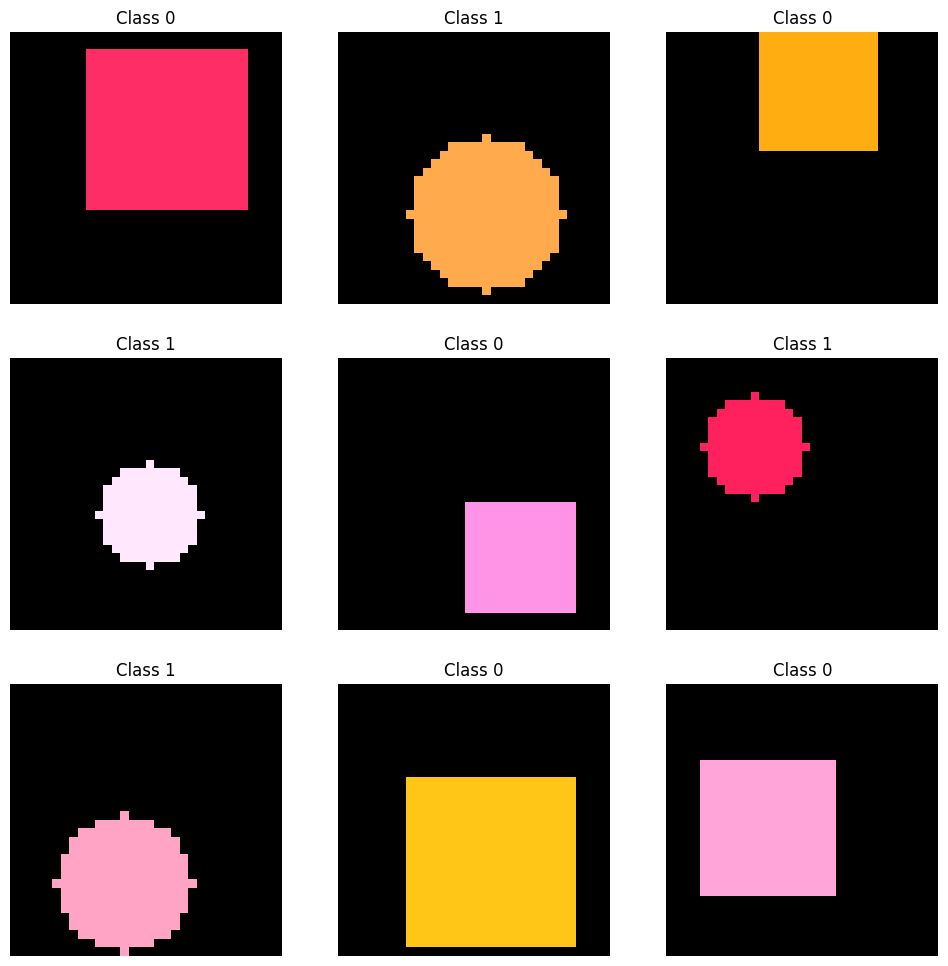

In [23]:
fig = plt.figure(figsize=(12, 12))

for img_index, single_dl_element in enumerate(train_dl.dataset):    
    if img_index == 9:
        break
    numpy_input = single_dl_element.input.detach().cpu().numpy()
    ax = fig.add_subplot(3, 3, img_index+1)
    ax.imshow(numpy_input)
    ax.axis('off')
    ax.set_title(f"Class {torch.argmax(single_dl_element.target).item()}")

plt.show()

In [24]:
model = DummyCnn(
    nb_classes=params.nb_classes,
    nb_input_channels=len(params.c_indexes) * len(params.z_indexes),
)

manager = CnnModelManager(model, params, ClassificationAccuracy)

optimizer = optim.Adam(
    model.parameters(), lr=float(params.learning_rate), betas=(params.beta1, params.beta2),
)  # define the optimization

loss_function = nn.CrossEntropyLoss()  # define the loss function

Current commit hash: 6433162bd9c37cfd44362ceb6a74f4fe443165d0


In [25]:
manager.fit(train_dl, val_dl, optimizer, loss_function)

Training in progress: 100.0% | Local step 50 | Epoch 25
Best model saved at epoch 25.

Training successfully finished in 0:02:33.874158.


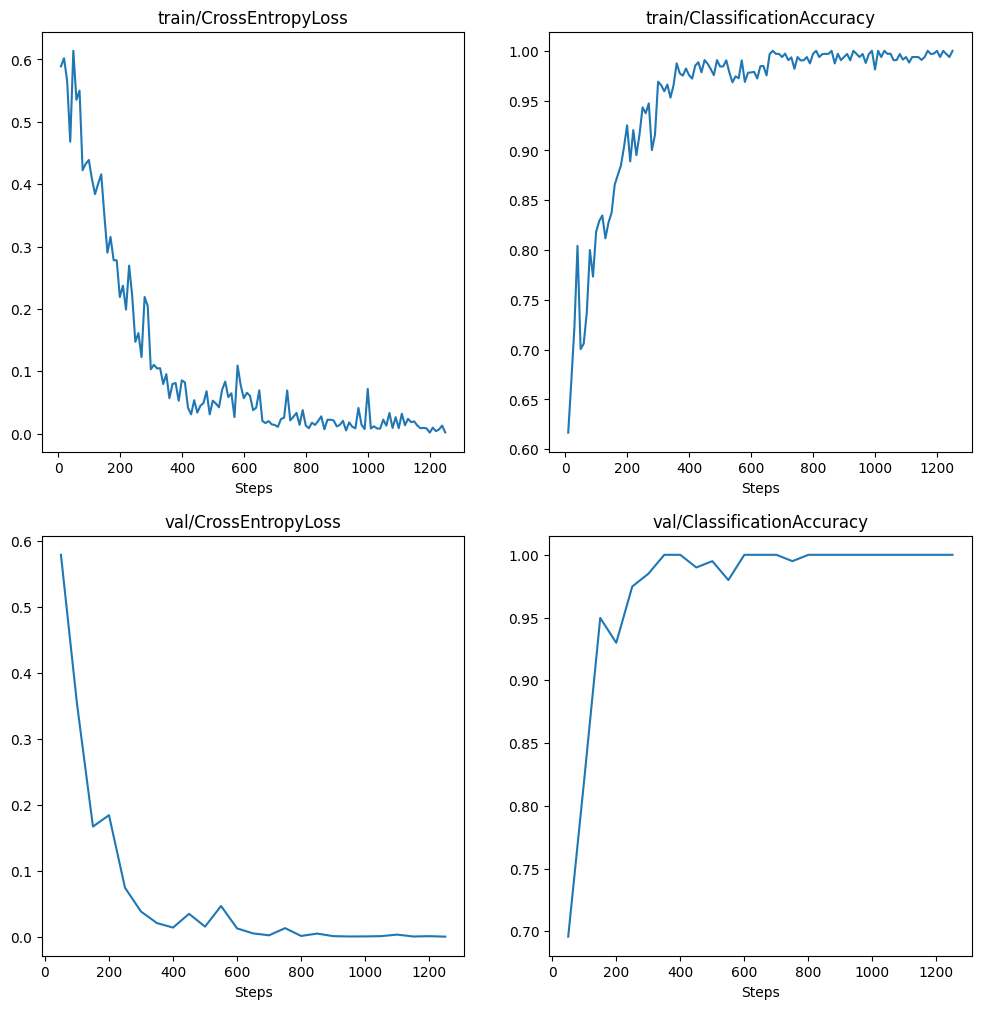

In [27]:
manager.display_training_curves()


Predicting with early stopping model.
Model evaluation in progress: 100.0% | Batch #6
Average ClassificationAccuracy: 1.0

Predicting with final model.
Model evaluation in progress: 100.0% | Batch #6
Average ClassificationAccuracy: 1.0


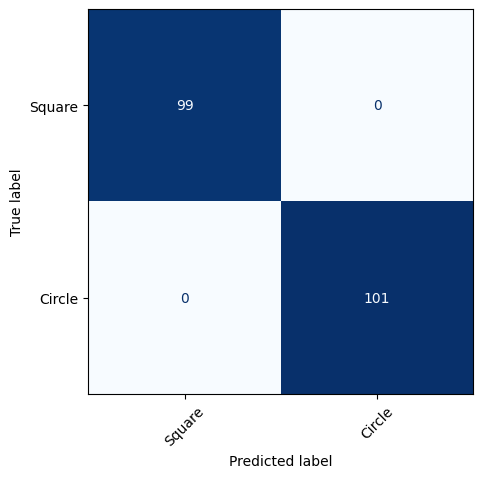

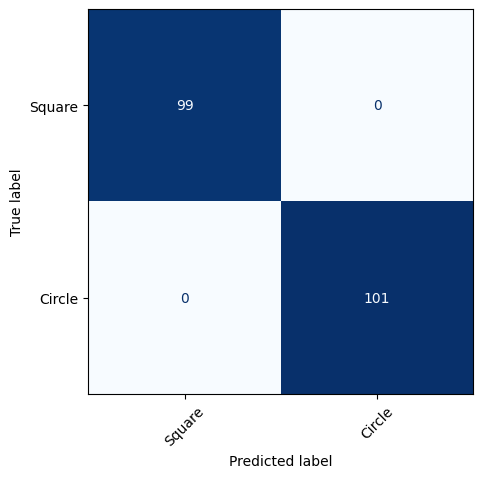

In [26]:
for model_path, name in zip(
    [manager.model_save_path_early_stopping, manager.model_save_path],
    ["early stopping", "final"],
):
    print(f"\nPredicting with {name} model.")
    # Update model with saved one
    manager.model.load_state_dict(torch.load(model_path))
    manager.predict(test_dl)